In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'epoch_jd', 'epoch_fr',
              #'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 
             ]

# Load all data...
train_df = pd.read_pickle('data/train.pkl' ) # Time: 26.9s
test_df = pd.read_pickle('data/test.pkl' ) # Time: 5s

In [2]:
%%time
# Percent of NORADs to use during training...
perc = 0.05
norad_count = int(len(train_df.NORAD_CAT_ID.unique()) * perc)
train_df = train_df[train_df.NORAD_CAT_ID.isin(train_df.NORAD_CAT_ID.unique()[:norad_count])].reset_index(drop=True)

# Limit to 1990 and after...
train_df = train_df.loc[train_df.EPOCH >= '1990-01-01'].reset_index(drop=True)
test_df = test_df.loc[test_df.EPOCH >= '1990-01-01'].reset_index(drop=True)

# Drop large mean motions
train_df = train_df[abs(train_df.MEAN_MOTION) < 20].reset_index(drop=True)  # drops 1
test_df = test_df[abs(test_df.MEAN_MOTION) < 20].reset_index(drop=True) # drops 2

# Drop large bstars
train_df = train_df[abs(train_df.BSTAR) < 10].reset_index(drop=True)  # drops 779 / 9745803
test_df = test_df[abs(test_df.BSTAR) < 10].reset_index(drop=True) # drops 187 / 8309251 (on 5%)

CPU times: user 17.5 s, sys: 7.4 s, total: 24.9 s
Wall time: 24.9 s


|Data Change History | Time |
|:-|-|
|10% of all TLEs|8s|
|20% of all TLEs|14s|
|10% of all TLEs, only after 1990|11s|

In [3]:
%%time
import clean_data

for df in [train_df, test_df]:
    df = clean_data.add_epoch_data(df)
    df = clean_data.normalize_all_columns(df)
    
train_idx_map = clean_data.create_index_map(train_df)
test_idx_map = clean_data.create_index_map(test_df)

train_model_df = train_df[model_cols]
test_model_df = test_df[model_cols]

X_test,y_test = clean_data.build_xy(test_model_df,test_idx_map)  # create input/label pair

100%|██████████| 2705/2705 [00:42<00:00, 63.33it/s]


CPU times: user 2min 49s, sys: 8.86 s, total: 2min 57s
Wall time: 2min 57s


|Data Change History | Time |
|:-|-|
|10% of all TLEs|5min|
|20% of all TLEs|10min|
|10% of all TLEs, only after 1990|3min|

In [18]:
%%time
import train

model = train.create_model(model_cols=model_cols,
                           layer1=300, relu1=True, #drop1=0.5,
                           layer2=300, relu2=True, #drop2=0.5,
                           layer3=100, relu3=True, #drop3=0.5,
                           layer4=100, relu4=True, #drop4=0.5,
                           layer5=100, relu5=True, #drop5=0.5,
                          )
model

CPU times: user 7.4 ms, sys: 4.29 ms, total: 11.7 ms
Wall time: 10.3 ms


NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=7, bias=True)
  )
)

In [19]:
%%time

device='cpu'

# Simple model with one hidden layer
# trained_model, loss_output = train.train_model(train_model_df, train_idx_map, batchSize=200,
#                           print_itr=10000, numEpochs=10, model_cols=model_cols,
#                           learningRate=0.01, device=device, num_workers=10,
#                           loss='L2', hiddenSize=10)

trained_model, loss_output = train.train_model(train_model_df, train_idx_map, batchSize=200,
                                               print_itr=40000, numEpochs=20, model_cols=model_cols,
                                               learningRate=0.00001, device=device, num_workers=5,
                                               loss='L2', model=model)

y_pred = train.predict(trained_model, X_test, device=device) # get predictions for each train
y_pred_df = pd.DataFrame(y_pred, columns=test_model_df.columns[:-2])  # put results into a dataframe

>>> Loading dataset
>>> Beginning training!
Epoch [1/20], Batch [40000/41618], Loss: 0.04156007617712021, Time: 165s
Epoch [2/20], Batch [40000/41618], Loss: 0.05254204943776131, Time: 178s
Epoch [3/20], Batch [40000/41618], Loss: 0.04465080425143242, Time: 185s
Epoch [4/20], Batch [40000/41618], Loss: 0.05972916632890701, Time: 185s
Epoch [5/20], Batch [40000/41618], Loss: 0.038648732006549835, Time: 188s
Epoch [6/20], Batch [40000/41618], Loss: 0.06001022458076477, Time: 188s
Epoch [7/20], Batch [40000/41618], Loss: 0.07177039235830307, Time: 186s
Epoch [8/20], Batch [40000/41618], Loss: 0.03439106047153473, Time: 187s
Epoch [9/20], Batch [40000/41618], Loss: 0.04079705476760864, Time: 187s
Epoch [10/20], Batch [40000/41618], Loss: 0.05798305943608284, Time: 190s
Epoch [11/20], Batch [40000/41618], Loss: 0.03884825110435486, Time: 188s
Epoch [12/20], Batch [40000/41618], Loss: 0.039377856999635696, Time: 184s
Epoch [13/20], Batch [40000/41618], Loss: 0.041697729378938675, Time: 191s


    Test set MAE (L1) loss: 0.12849118935595819
    Test set MSE (L2) loss: 0.05907722857500306


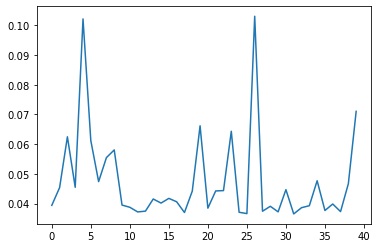

In [20]:
import matplotlib.pyplot as plt

def print_loss(loss):
    return plt.plot([float(l['loss']) for l in loss])

print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_pred_df)}')

print_loss(loss_output)

## finding hyper parameters

In [4]:
%%time
import train

device='cpu'

batchSizes=[200,2000]
learningRates=[0.00001, 0.0001, 0.001]

for batchSize in batchSizes:
    for learningRate in learningRates:
        model = train.train_model(train_model_df, train_idx_map, batchSize=batchSize,
                          print_itr=0, numEpochs=1, model_cols=model_cols,
                          learningRate=learningRate, device=device, num_workers=5,
                          loss='L2', hiddenSize=10)

        y_pred = train.predict(model, X_test, device=device) # get predictions for each train
        y_pred_df = pd.DataFrame(y_pred, columns=test_model_df.columns[:-2])  # put results into a dataframe
        print(f'>>> Results for batchSize = {batchSize} / learningRate = {learningRate}:')
        print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_pred_df)}')
        print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_pred_df)}')

# model = train.train_model(train_model_df, train_idx_map, batchSize=200,
#                           print_itr=10000, numEpochs=10, model_cols=model_cols,
#                           learningRate=0.0001, device=device, num_workers=5,
#                           loss='L2', hiddenSize=10)

# y_pred = train.predict(model, X_test, device=device) # get predictions for each train
# y_pred_df = pd.DataFrame(y_pred, columns=test_model_df.columns[:-2])  # put results into a dataframe

>>> Loading model
>>> Loading dataset
>>> Beginning training!
Final loss: 0.06986154615879059
>>> Results for batchSize = 200 / learningRate = 1e-05:
    Test set MAE (L1) loss: 0.15202310246318226
    Test set MSE (L2) loss: 0.14742363947638187
>>> Loading model
>>> Loading dataset
>>> Beginning training!
Final loss: 0.06339056044816971
>>> Results for batchSize = 200 / learningRate = 0.0001:
    Test set MAE (L1) loss: 0.1339450425649999
    Test set MSE (L2) loss: 0.13874329771633204
>>> Loading model
>>> Loading dataset
>>> Beginning training!
Final loss: 0.06071564927697182
>>> Results for batchSize = 200 / learningRate = 0.001:
    Test set MAE (L1) loss: 0.13100660190346378
    Test set MSE (L2) loss: 0.13744730606731054
>>> Loading model
>>> Loading dataset
>>> Beginning training!
Final loss: 0.3394209146499634
>>> Results for batchSize = 2000 / learningRate = 1e-05:
    Test set MAE (L1) loss: 0.3994797786758509
    Test set MSE (L2) loss: 0.4587655424336244
>>> Loading model


In [5]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_pred_df)}')

    Test set MAE (L1) loss: 0.13291584041229298
    Test set MSE (L2) loss: 0.13800174659503023


# Loss Tracking

|Test L1 Loss | Test L2 Loss | NN Change History | Time |
|:-|:-|:-|-|
|0.1234|21.7614|norads=10%, epochs=10, batchSize=200,<br> learn=0.0001, device=cpu, loss=l2,<br> num_workers=5, hidden=300|28min 39s|
|0.1235|34.4868|num_workers=20|28min 54s|
|0.1222|30.8207|norads=20%, num_workers=5|53min 47s|
|0.1219|26.2414|norads=5%, tles-after-1990|12min 46s|
|0.1217|0.1226|remove-high-mean-motion|13min 22s|
|0.1211|0.1235|norads=10%|27min 35s|
|0.1221|0.1232|hidden=10|22min 33s|
|0.1330|0.1380|updated mean_motion standardization|24min 16s|
|0.1329|0.1380|norads=5%|12min 36s|

In [6]:
clean_data.normalize_all_columns(y_test.head().copy(), reverse=True)

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000043,99.0841,269.4983,0.006611,275.3876,239.5037,13.902003
1,0.000130,99.3282,148.3144,0.006702,263.9172,95.4353,13.892284
2,0.000065,99.4669,275.1372,0.006796,130.6204,230.0887,13.896146
3,0.000717,98.8809,82.4447,0.006932,314.2741,45.2898,13.874495
4,0.000047,99.1070,90.7191,0.006782,51.5472,14.5132,13.901845


In [7]:
clean_data.normalize_all_columns(y_pred_df.head().copy(), reverse=True)  # reverse the normalization

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000641,99.336617,178.869095,0.005620,176.695450,180.626968,14.041883
1,0.000561,98.893776,180.485718,0.007194,178.840179,181.855469,13.803382
2,0.000875,99.383141,179.104202,0.005948,177.136353,181.034882,13.972489
3,0.001005,99.515404,180.127548,0.007452,178.695847,181.737198,13.788252
4,0.000961,98.992477,178.821701,0.005122,176.370514,180.899994,14.097835


In [14]:
np.argmax(y_se[:,5])

6356746

In [15]:
y_pred_df.sort_values(by='MEAN_MOTION', ascending=False)

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
6620653,-0.133392,0.278333,0.506217,0.137734,0.520872,0.491481,1.884373
6686468,-0.039728,0.343702,0.494812,0.168812,0.511880,0.488782,1.821298
9774453,-0.054346,0.287659,0.493091,0.093249,0.522456,0.478334,1.711937
9768541,-0.057924,0.286515,0.495393,0.060983,0.525184,0.477524,1.709254
9768535,-0.057818,0.286494,0.495364,0.061076,0.525181,0.477521,1.707914
...,...,...,...,...,...,...,...
9063295,31.834158,15.055138,13.914037,19.002722,5.885316,15.241354,-14.248805
6580660,30.925592,14.689282,13.482357,18.587982,5.678499,14.795154,-14.342788
830231,-3.874067,4.025919,3.924853,4.683432,1.919658,3.885359,-22.654819
6710137,-5.385159,4.586196,4.871517,6.216354,2.326429,4.814487,-38.044907


In [16]:
y_test.iloc[6356278]

BSTAR                 0.002000
INCLINATION           0.351598
RA_OF_ASC_NODE        0.716799
ECCENTRICITY          0.894146
ARG_OF_PERICENTER     0.127487
MEAN_ANOMALY          0.983608
MEAN_MOTION         -11.742342
Name: 6356278, dtype: float64

In [17]:
X_test.iloc[6356278]

BSTAR                -0.008146
INCLINATION           0.346709
RA_OF_ASC_NODE        0.524887
ECCENTRICITY          0.904386
ARG_OF_PERICENTER     0.134282
MEAN_ANOMALY          0.151539
MEAN_MOTION         -11.740535
epoch_jd              0.875739
epoch_fr              0.379943
epoch_jd_y            0.853795
epoch_fr_y            0.728873
Name: 6356278, dtype: float64

In [18]:
clean_data.normalize_all_columns(test_df.iloc[test_idx_map[6356278][0]].copy())

NORAD_CAT_ID                                                      9889
OBJECT_TYPE                                                     DEBRIS
OBJECT_NAME                                             COSMOS 862 DEB
TLE_LINE1            1 09889U 76105F   13265.37994281 -.00000470  0...
TLE_LINE2            2 09889 062.4076 188.9592 7397089 048.3414 054...
MEAN_MOTION_DOT                                              -0.000005
MEAN_MOTION_DDOT                                                   0.0
BSTAR                                                         -0.16292
INCLINATION                                                   0.001926
RA_OF_ASC_NODE                                                0.001458
ECCENTRICITY                                                  0.967055
ARG_OF_PERICENTER                                             0.000373
MEAN_ANOMALY                                                  0.000421
MEAN_MOTION                                                 -25.490535
EPOCH 

In [5]:
test_df.MEAN_MOTION.describe()

count    9.774841e+06
mean     7.071389e-03
std      1.207834e+00
min     -1.276513e+01
25%     -2.762912e-01
50%      2.739096e-01
75%      6.174967e-01
max      2.828760e+00
Name: MEAN_MOTION, dtype: float64

In [6]:
train_df.MEAN_MOTION.describe()

count    8.323670e+06
mean    -6.630719e-02
std      1.000383e+00
min     -1.275089e+01
25%     -4.353721e-01
50%      1.359139e-01
75%      5.215565e-01
max      2.800927e+00
Name: MEAN_MOTION, dtype: float64

In [7]:
test_df.MEAN_MOTION.sort_values()

788213    -12.765129
6092401   -12.747369
6389269   -12.747307
786326    -12.747295
4733230   -12.747279
             ...    
983840      2.787466
3448121     2.792547
1608752     2.800919
4898083     2.801152
983842      2.828760
Name: MEAN_MOTION, Length: 9774841, dtype: float64

In [8]:
train_df.MEAN_MOTION.sort_values()

880177    -12.750892
1015425   -12.747301
930452    -12.747238
930453    -12.747235
987189    -11.814547
             ...    
6114164     2.680907
6313579     2.692586
6258520     2.736366
5326336     2.755610
5983771     2.800927
Name: MEAN_MOTION, Length: 8323670, dtype: float64

In [23]:
test_idx_map[9393426][0]

6640912